In [1]:
import rom_inverse as ri
import torch
import matplotlib.pyplot as plt
import sklearn.gaussian_process.kernels as kernels
from poisson_fem import PoissonFEM
import ROM
import numpy as np

In [2]:
permeability_random_field = ri.DiscretizedRandomField(kernel=kernels.RBF(length_scale=[.01, .1]))

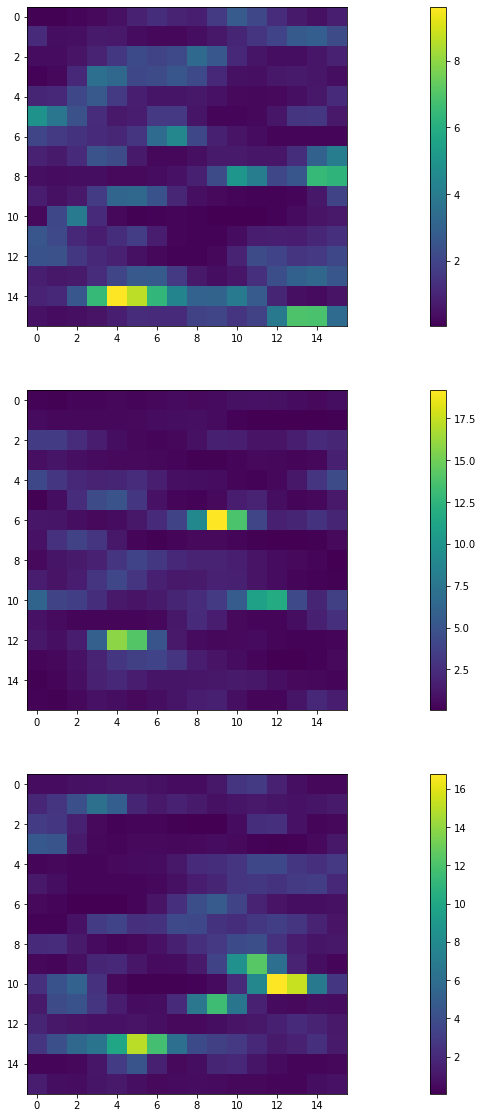

In [3]:
permeability_random_field.plot_realizations()

In [4]:
lin_dim_fom = 32                      # Linear number of rom elements
a = torch.tensor([-1, 0, 0])               # Boundary condition function coefficients


# Define mesh and boundary conditions
mesh = PoissonFEM.RectangularMesh(torch.ones(lin_dim_fom)/lin_dim_fom)
# mesh.plot()

def origin(x):
    return torch.abs(x[0]) < torch.finfo(torch.float32).eps and torch.abs(x[1]) < torch.finfo(torch.float32).eps

def ess_boundary_fun(x):
    return 0.0
mesh.set_essential_boundary(origin, ess_boundary_fun)

def domain_boundary(x):
    # unit square
    return torch.abs(x[0]) < torch.finfo(torch.float32).eps or torch.abs(x[1]) < torch.finfo(torch.float32).eps or \
            torch.abs(x[0]) > 1.0 - torch.finfo(torch.float32).eps or torch.abs(x[1]) > 1.0 - torch.finfo(torch.float32).eps
mesh.set_natural_boundary(domain_boundary)

def flux(x):
    q = np.array([a[0] + a[2]*x[1], a[1] + a[2]*x[0]])
    return q

In [5]:
#Specify right hand side and stiffness matrix
rhs = PoissonFEM.RightHandSide(mesh)
rhs.set_natural_rhs(mesh, flux)
K = PoissonFEM.StiffnessMatrix(mesh)
rhs.set_rhs_stencil(mesh, K)

In [6]:
# define fom
fom = ROM.ROM(mesh, K, rhs, lin_dim_fom**2)
# Change for non unit square domains!!
xx, yy = torch.meshgrid((torch.linspace(0, 1, lin_dim_fom), torch.linspace(0, 1, lin_dim_fom)))
X = torch.cat((xx.flatten().unsqueeze(1), yy.flatten().unsqueeze(1)), 1)
fom.mesh.get_interpolation_matrix(X)

In [7]:
fom_autograd = fom.get_autograd_fun()

In [8]:
lmbda = permeability_random_field.sample(n_samples=3)
lmbda = torch.ones(lin_dim_fom**2, 3)

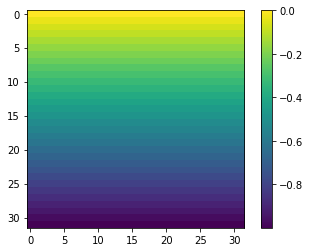

In [9]:
img = plt.imshow(fom_autograd(lmbda[:, 0]).view(lin_dim_fom, lin_dim_fom))
plt.colorbar(img)